# London Underground Passenger Prediction Model

This notebook develops a regression model to predict passenger entry counts (`entrytapcount`) using carefully selected features that avoid data leakage and multicollinearity.


## 1. Setup and Data Loading


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')

print("Libraries imported successfully")


Libraries imported successfully


In [5]:
# Load the prepared dataset
df = pd.read_csv('../data/processed/passengers_enriched_2023_prepared.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Original dataset shape: (147103, 33)
Columns: ['station_uid', 'line', 'farezones', 'entrytapcount', 'exittapcount', 'year', 'month', 'day', 'day_of_year', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'is_weekend', 'is_event', 'expected_attendance', 'max_temp', 'min_temp', 'mean_temp', 'precipitation_amount', 'relative_humidity', 'cloud_cover', 'sunshine_duration', 'sea_level_pressure', 'service_operated_allweek_pct', 'service_operated_weekday_pct', 'service_operated_weekend_pct', 'kilometres_operated', 'wifi', 'bluebadgecarparking', 'bluebadgecarparkspaces', 'toilet_isaccessible', 'toilet_isfeecharged']

First few rows:


,station_uid,line,farezones,entrytapcount,exittapcount,year,month,day,day_of_year,month_sin,month_cos,day_of_year_sin,day_of_year_cos,is_weekend,is_event,expected_attendance,max_temp,min_temp,mean_temp,precipitation_amount,relative_humidity,cloud_cover,sunshine_duration,sea_level_pressure,service_operated_allweek_pct,service_operated_weekday_pct,service_operated_weekend_pct,kilometres_operated,wifi,bluebadgecarparking,bluebadgecarparkspaces,toilet_isaccessible,toilet_isfeecharged
0,910GACTNCTL,mildmay,3,779,709,2023,1,1,1,0.5,0.866025,0.017213,0.999852,True,0,0.0,13.4,5.2,7.2,4.6,81.0,7.0,0.0,1008.0,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
1,910GACTNCTL,mildmay,3,1077,1135,2023,1,2,2,0.5,0.866025,0.034422,0.999407,False,0,0.0,13.4,5.2,7.2,0.4,86.0,3.0,5.2,1016.9,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
2,910GACTNCTL,mildmay,3,735,597,2023,1,3,3,0.5,0.866025,0.051620,0.998667,False,0,0.0,13.9,2.1,7.8,3.0,93.0,7.0,0.0,1018.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
3,910GACTNCTL,mildmay,3,818,735,2023,1,4,4,0.5,0.866025,0.068802,0.997630,False,0,0.0,13.5,9.2,11.6,0.2,82.0,6.0,0.4,1014.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown
4,910GACTNCTL,mildmay,3,1237,1247,2023,1,5,5,0.5,0.866025,0.085965,0.996298,False,0,0.0,12.7,8.9,11.2,2.4,82.0,8.0,0.4,1018.6,90.201755,90.905127,88.184147,190892.969975,True,False,0.0,unknown,unknown


## 2. Feature Selection - Remove Data Leakage and Redundancy


In [8]:
# Define target variable
target = 'entrytapcount'

print(f"Target variable: {target}")
print(f"Target statistics:")
print(df[target].describe())


Target variable: entrytapcount
Target statistics:
count    147103.000000
mean       7637.995044
std        9758.516839
min           0.000000
25%        2228.000000
50%        4438.000000
75%        8801.000000
max      116723.000000
Name: entrytapcount, dtype: float64


In [10]:
# Step 1: Remove data leakage fields (not known at prediction time)
leakage_fields = [
    'exittapcount',  # We don't know exit count when predicting entry count
    'service_operated_allweek_pct',   # Same-day actuals
    'service_operated_weekday_pct',   # Same-day actuals
    'service_operated_weekend_pct',   # Same-day actuals
    'kilometres_operated'             # Network totals
]

print(f"Removing data leakage fields: {leakage_fields}")
df_clean = df.drop(columns=[col for col in leakage_fields if col in df.columns])
print(f"Shape after removing leakage: {df_clean.shape}")

Removing data leakage fields: ['exittapcount', 'service_operated_allweek_pct', 'service_operated_weekday_pct', 'service_operated_weekend_pct', 'kilometres_operated']
Shape after removing leakage: (147103, 28)


In [12]:
# Step 2: Remove redundant calendar features (keep only cyclical day_of_year)
redundant_calendar = [
    'year',
    'month', 
    'day',
    'day_of_year',
    'month_sin',
    'month_cos'
]

print(f"Removing redundant calendar fields: {redundant_calendar}")
print(f"Keeping: day_of_year_sin, day_of_year_cos, is_weekend")
df_clean = df_clean.drop(columns=[col for col in redundant_calendar if col in df_clean.columns])
print(f"Shape after removing redundant calendar: {df_clean.shape}")


Removing redundant calendar fields: ['year', 'month', 'day', 'day_of_year', 'month_sin', 'month_cos']
Keeping: day_of_year_sin, day_of_year_cos, is_weekend
Shape after removing redundant calendar: (147103, 22)


In [14]:
# Step 3: Remove redundant weather features (keep mean_temp only)
redundant_weather = [
    'min_temp',
    'max_temp'
]

print(f"Removing redundant weather fields: {redundant_weather}")
print(f"Keeping: mean_temp (most representative)")
df_clean = df_clean.drop(columns=[col for col in redundant_weather if col in df_clean.columns])
print(f"Shape after removing redundant weather: {df_clean.shape}")


Removing redundant weather fields: ['min_temp', 'max_temp']
Keeping: mean_temp (most representative)
Shape after removing redundant weather: (147103, 20)


In [16]:
# Step 4: Clean up toilet/amenity features
# Drop toilet_isfeecharged entirely
if 'toilet_isfeecharged' in df_clean.columns:
    df_clean = df_clean.drop(columns=['toilet_isfeecharged'])
    print("Dropped toilet_isfeecharged")

# Clean toilet_isaccessible to be 0/1 only
if 'toilet_isaccessible' in df_clean.columns:
    print(f"toilet_isaccessible values before cleaning: {df_clean['toilet_isaccessible'].value_counts()}")
    
    # Convert to clean 0/1 (True->1, False->0, 'unknown'->0)
    def clean_toilet_accessible(value):
        if pd.isna(value):
            return 0
        if isinstance(value, bool):
            return 1 if value else 0
        if isinstance(value, str):
            value_lower = value.lower()
            if value_lower == 'true':
                return 1
            elif value_lower == 'false':
                return 0
            else:  # 'unknown' or any other string
                return 0
        return 0  # fallback
    
    df_clean['toilet_isaccessible'] = df_clean['toilet_isaccessible'].apply(clean_toilet_accessible)
    print(f"toilet_isaccessible values after cleaning: {df_clean['toilet_isaccessible'].value_counts()}")

print(f"Final shape after all cleaning: {df_clean.shape}")


Dropped toilet_isfeecharged
toilet_isaccessible values before cleaning: toilet_isaccessible
unknown    90858
True       32367
False      23878
Name: count, dtype: int64
toilet_isaccessible values after cleaning: toilet_isaccessible
0    114736
1     32367
Name: count, dtype: int64
Final shape after all cleaning: (147103, 19)


In [18]:
# Summary of final features
print("=== FINAL FEATURE SET ===")
print(f"Total features: {df_clean.shape[1] - 1} (excluding target)")
print(f"Target: {target}")
print(f"\nFinal features:")

features = [col for col in df_clean.columns if col != target]
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")

# Check data types
print(f"\nFeature types:")
print(df_clean.dtypes.value_counts())

# Check for missing values
missing = df_clean.isnull().sum().sum()
print(f"\nMissing values: {missing}")
if missing == 0:
    print("✅ No missing values - dataset is clean!")
else:
    print("⚠️ Missing values found:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


=== FINAL FEATURE SET ===
Total features: 18 (excluding target)
Target: entrytapcount

Final features:
 1. station_uid
 2. line
 3. farezones
 4. day_of_year_sin
 5. day_of_year_cos
 6. is_weekend
 7. is_event
 8. expected_attendance
 9. mean_temp
10. precipitation_amount
11. relative_humidity
12. cloud_cover
13. sunshine_duration
14. sea_level_pressure
15. wifi
16. bluebadgecarparking
17. bluebadgecarparkspaces
18. toilet_isaccessible

Feature types:
float64    10
object      3
int64       3
bool        3
Name: count, dtype: int64

Missing values: 0
✅ No missing values - dataset is clean!


## 3. Data Preparation for Modeling


In [21]:
# Prepare features and target
X = df_clean.drop(columns=[target])
y = df_clean[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Convert boolean columns to integers (0/1) so they're treated as numeric
boolean_cols = X.select_dtypes(include=['bool']).columns.tolist()
if boolean_cols:
    print(f"\nConverting boolean columns to integers: {boolean_cols}")
    for col in boolean_cols:
        print(f"  {col}: {X[col].unique()} -> ", end="")
        X[col] = X[col].astype(int)
        print(f"{X[col].unique()}")

# Also ensure toilet_isaccessible is properly converted to integer (should be done in cleaning step)
if 'toilet_isaccessible' in X.columns:
    if X['toilet_isaccessible'].dtype == 'object':
        print(f"\n⚠️ toilet_isaccessible still has object type, converting to integer...")
        print(f"  Current values: {X['toilet_isaccessible'].unique()}")
        # This should already be done in the cleaning step, but ensure it's numeric
        X['toilet_isaccessible'] = pd.to_numeric(X['toilet_isaccessible'], errors='coerce').fillna(0).astype(int)
        print(f"  After conversion: {X['toilet_isaccessible'].unique()}")
    else:
        print(f"\n✅ toilet_isaccessible is already numeric: {X['toilet_isaccessible'].dtype}")

# Identify feature types for preprocessing
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Features shape: (147103, 18)
Target shape: (147103,)

Converting boolean columns to integers: ['is_weekend', 'wifi', 'bluebadgecarparking']
  is_weekend: [ True False] -> [1 0]
  wifi: [ True False] -> [1 0]
  bluebadgecarparking: [False  True] -> [0 1]

✅ toilet_isaccessible is already numeric: int64

Numeric features (15): ['day_of_year_sin', 'day_of_year_cos', 'is_weekend', 'is_event', 'expected_attendance', 'mean_temp', 'precipitation_amount', 'relative_humidity', 'cloud_cover', 'sunshine_duration', 'sea_level_pressure', 'wifi', 'bluebadgecarparking', 'bluebadgecarparkspaces', 'toilet_isaccessible']
Categorical features (3): ['station_uid', 'line', 'farezones']


In [23]:
# Train/test split (chronological based on day_of_year features)
if 'day_of_year_sin' in X.columns and 'day_of_year_cos' in X.columns:
    # Create temporal ordering using cyclical features
    # Convert cyclical back to approximate day of year for sorting
    day_approx = np.arctan2(X['day_of_year_sin'], X['day_of_year_cos']) * 365 / (2 * np.pi)
    day_approx = (day_approx + 365) % 365  # Ensure positive
    
    sorted_idx = day_approx.sort_values().index
    split_point = int(0.8 * len(sorted_idx))
    
    train_idx = sorted_idx[:split_point]
    test_idx = sorted_idx[split_point:]
    
    print("Using chronological split based on day_of_year cyclical features")
    print(f"Train period: days {day_approx.loc[train_idx].min():.0f} to {day_approx.loc[train_idx].max():.0f}")
    print(f"Test period: days {day_approx.loc[test_idx].min():.0f} to {day_approx.loc[test_idx].max():.0f}")
else:
    # Fallback to random split
    train_idx, test_idx = train_test_split(X.index, test_size=0.2, random_state=42)
    print("Using random split")

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Using chronological split based on day_of_year cyclical features
Train period: days 0 to 291
Test period: days 291 to 364

Train set: (117682, 18)
Test set: (29421, 18)


## 4. Model Training


In [25]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Create full pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Model pipeline created")
print("Components:")
print("1. StandardScaler for numeric features")
print("2. OneHotEncoder for categorical features")
print("3. Linear Regression")


Model pipeline created
Components:
1. StandardScaler for numeric features
2. OneHotEncoder for categorical features
3. Linear Regression


In [27]:
# Train the model
print("Training model...")
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

print("Model training completed")


Training model...
Model training completed


## 5. Model Evaluation


In [29]:
# Evaluate model performance
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Performance:")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print("=== MODEL EVALUATION ===")
train_metrics = evaluate_model(y_train, y_pred_train, "Training Set")
test_metrics = evaluate_model(y_test, y_pred_test, "Test Set")

# Check for overfitting
r2_diff = train_metrics['R2'] - test_metrics['R2']
print(f"\nOverfitting Analysis:")
print(f"  R² difference (train - test): {r2_diff:.4f}")

if r2_diff > 0.1:
    print("  ⚠️ Possible overfitting detected")
elif r2_diff > 0.05:
    print("  ⚡ Slight overfitting")
else:
    print("  ✅ No significant overfitting")

# Model interpretation
print(f"\nModel Interpretation:")
print(f"  Average passenger count: {y.mean():.0f}")
print(f"  Test MAE as % of average: {(test_metrics['MAE'] / y.mean()) * 100:.1f}%")
print(f"  Model explains {test_metrics['R2']*100:.1f}% of variance in passenger counts")


=== MODEL EVALUATION ===

Training Set Performance:
  MAE:  1,275.21
  RMSE: 2,515.45
  R²:   0.9293

Test Set Performance:
  MAE:  1,738.46
  RMSE: 3,470.48
  R²:   0.8976

Overfitting Analysis:
  R² difference (train - test): 0.0318
  ✅ No significant overfitting

Model Interpretation:
  Average passenger count: 7638
  Test MAE as % of average: 22.8%
  Model explains 89.8% of variance in passenger counts


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 6. Model Visualization


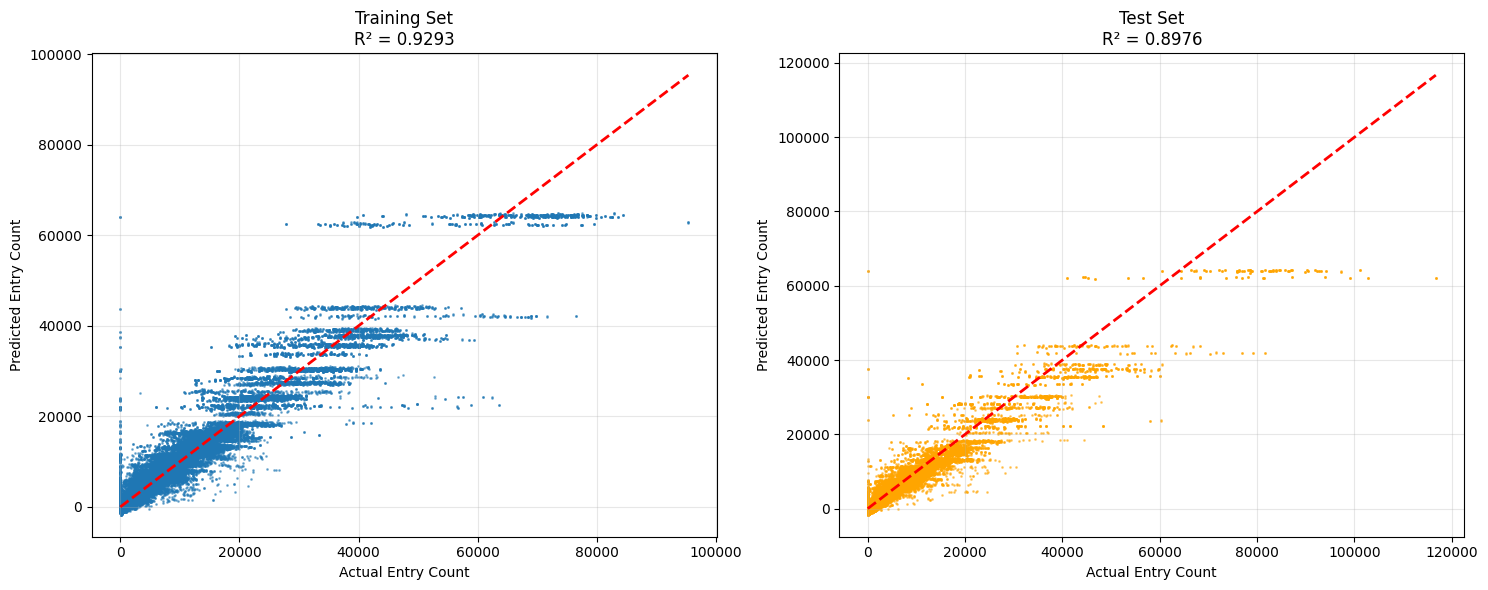

In [31]:
# Prediction vs Actual scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax1.scatter(y_train, y_pred_train, alpha=0.5, s=1)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Entry Count')
ax1.set_ylabel('Predicted Entry Count')
ax1.set_title(f'Training Set\nR² = {train_metrics["R2"]:.4f}')
ax1.grid(True, alpha=0.3)

# Test set
ax2.scatter(y_test, y_pred_test, alpha=0.5, s=1, color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Entry Count')
ax2.set_ylabel('Predicted Entry Count')
ax2.set_title(f'Test Set\nR² = {test_metrics["R2"]:.4f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


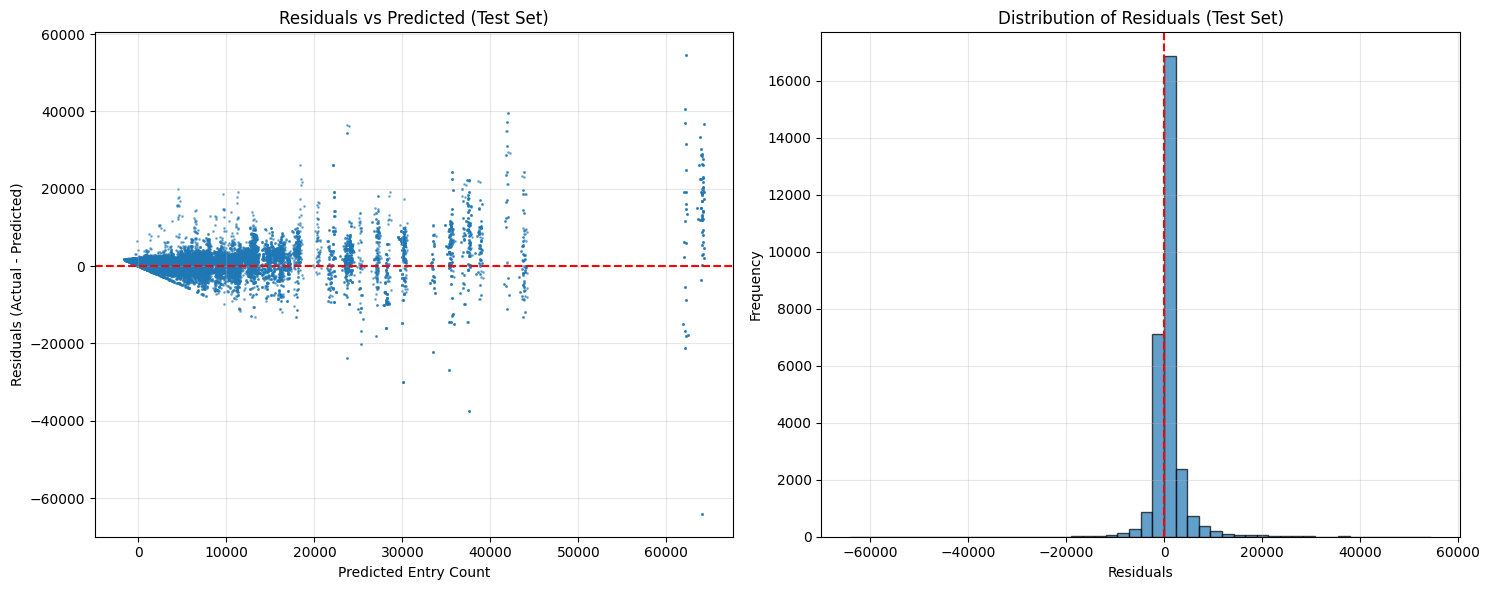

Residual Statistics (Test Set):
  Mean: 924.15
  Std:  3345.23
  Min:  -64064.70
  Max:  54524.48


In [33]:
# Residual analysis
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
ax1.scatter(y_pred_test, residuals_test, alpha=0.5, s=1)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Entry Count')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.set_title('Residuals vs Predicted (Test Set)')
ax1.grid(True, alpha=0.3)

# Residuals histogram
ax2.hist(residuals_test, bins=50, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Residuals (Test Set)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics (Test Set):")
print(f"  Mean: {residuals_test.mean():.2f}")
print(f"  Std:  {residuals_test.std():.2f}")
print(f"  Min:  {residuals_test.min():.2f}")
print(f"  Max:  {residuals_test.max():.2f}")


## Summary

This model predicts London Underground passenger entry counts using a clean feature set that:

1. **Avoids data leakage** by excluding same-day actuals and exit counts
2. **Reduces multicollinearity** by keeping only essential temporal and weather features
3. **Uses domain knowledge** to select the most predictive features
4. **Maintains interpretability** with a simple linear regression approach

### Final Feature Set:
- **Identifiers**: station_uid, line, farezones
- **Temporal**: day_of_year_sin, day_of_year_cos, is_weekend
- **Events**: is_event, expected_attendance
- **Weather**: mean_temp, precipitation_amount, relative_humidity, cloud_cover, sunshine_duration, sea_level_pressure
- **Infrastructure**: wifi, bluebadgecarparking, bluebadgecarparkspaces, toilet_isaccessible

### Key Improvements:
- Removed data leakage variables (exit counts, same-day service metrics)
- Kept only cyclical day_of_year features for temporal patterns
- Used only mean_temp to avoid weather multicollinearity
- Cleaned categorical variables to proper 0/1 encoding
- Used chronological train/test split for realistic evaluation
